In [148]:
# import library
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [237]:
# functions 
def plot_sample_image_from_batchdataset(batchset_name):
    # take class_names
    class_names = batchset_name.class_names
    # get one batch
    batch = batchset_name.take(1)
    # get random value
    position = randint(0, len(batch.get_single_element()[1]))
    # get image and label
    tuples = batch.get_single_element()[:]
    image = tuples[0][position]/255
    label = tuples[1][position]

    # print image
    plt.imshow(image)
    plt.title("Labeled as: {}".format(class_names[np.argmax(label)]))


def plot_history(model_history):
    pd.DataFrame(model_history.history)
    loss = model_history.history["loss"]
    val_loss = model_history.history["val_loss"]
    acc = model_history.history["accuracy"]
    val_acc = model_history.history["val_accuracy"]

    epochs = range(len(val_acc))

    plt.figure(figsize=(10,7))
    plt.subplot(1,2,1)
    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend(["Training", "Validation"])

    plt.subplot(1,2,2)
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.legend(["Training", "Validation"])


def plot_random_prediction(batchset_name, model):
    # take class_names
    class_names = batchset_name.class_names
    # get one batch
    batch = batchset_name.take(1)
    # get random value
    position = randint(0, len(batch.get_single_element()[1]))
    # get image and label
    tuples = batch.get_single_element()[:]
    image = tuples[0][position]
    label = tuples[1][position]

    prediction = model.predict(tf.expand_dims(image, axis=0))

    true = class_names[np.argmax(label)]
    pred = class_names[prediction.argmax()]

    # print image
    plt.imshow(image/255)
    if pred == true:
        title_color = "g"
    else:
        title_color = "r"

    plt.title("Labeled as: {}.\n Prediction is: {}".format(true, pred), c = title_color)
    plt.axis('off')

def fine_tune_historys(original_history, new_history, initial_epochs=4):

    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
             plt.ylim(), label='Start Fine Tuning')  # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
             plt.ylim(), label='Start Fine Tuning')  # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [193]:
# section of loading data

# path to data sets
test_dir = "/Users/korzeniewski/Downloads/10_food_classes_10_percent/test"
train_dir = "/Users/korzeniewski/Downloads/10_food_classes_10_percent/train"

# property of loading image
IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_data = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                image_size = IMG_SIZE,
                                                                label_mode = "categorical",
                                                                batch_size = BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                image_size = IMG_SIZE,
                                                                label_mode = "categorical",
                                                                batch_size = BATCH_SIZE,
                                                                shuffle = False)

Found 2500 files belonging to 10 classes.
Found 750 files belonging to 10 classes.


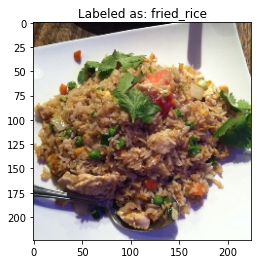

In [204]:
# visual data in datasets
plot_sample_image_from_batchdataset(train_data)

In [152]:
# create most important layers

# data augmentations layer
data_augemntation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)#, tf.keras.layers.experimental.preprocessing.Rescaling(1./255), tf.keras.layers.experimental.preprocessing.Normalization()
], name = "data_augmentation")

# load base model - resnet
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # the top layers is not included because we have other numbers of inputs - 10
base_model.trainable = False # freeze base model - transfer_learning

# Input layer
input = tf.keras.layers.Input(shape = (224,224,3), name = "input_layer") # number of input is automatically define

# define the model
x = data_augemntation(input)
x = base_model(x, training = False)
x = tf.keras.layers.GlobalMaxPooling2D(name = "Max_pooling")(x)
output = tf.keras.layers.Dense(10, activation = "softmax")(x)

model = tf.keras.Model(input, output)

# compile model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
            optimizer = tf.keras.optimizers.Adam(),
            metrics = ["accuracy"])

model.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 Max_pooling (GlobalMaxPooli  (None, 1280)             0         
 ng2D)                                                           
                                                                 
 dense_4 (Dense)             (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [153]:
# fit model - only on a part of data due to time of calculations
history = model.fit(train_data,
                        epochs=4,
                        steps_per_epoch=len(train_data),
                        validation_data = test_data,
                        validation_steps = len(test_data))

Epoch 1/4
79/79 [==============================] - 254s 3s/step - loss: 2.6284 - accuracy: 0.3760 - val_loss: 1.5218 - val_accuracy: 0.6227
Epoch 2/4
79/79 [==============================] - 251s 3s/step - loss: 1.2398 - accuracy: 0.6432 - val_loss: 1.2489 - val_accuracy: 0.6640
Epoch 3/4
79/79 [==============================] - 248s 3s/step - loss: 1.0085 - accuracy: 0.6972 - val_loss: 1.3234 - val_accuracy: 0.7013
Epoch 4/4
79/79 [==============================] - 240s 3s/step - loss: 0.8670 - accuracy: 0.7408 - val_loss: 1.0530 - val_accuracy: 0.7427


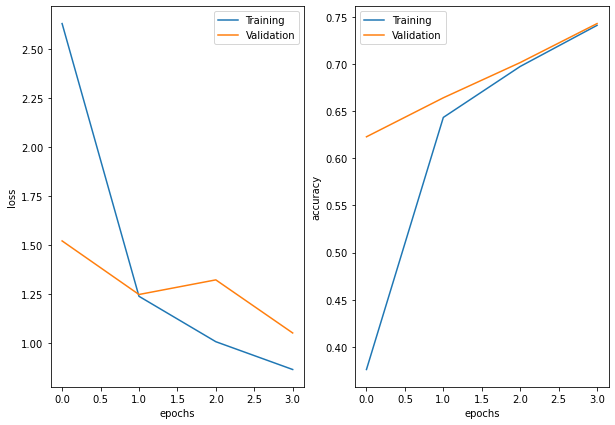

In [154]:
# plot history of learning
plot_history(history)

In [194]:
# make prediction on full test set
pred = model.predict(test_data, verbose=1)
class_pred = pred.argmax(axis=1)

# get true labels
labels = []
images = []
for image, label in test_data.unbatch():
    labels.append(int(label.numpy().argmax()))

24/24 [==============================] - 55s 2s/step


In [197]:
# make summary
from sklearn.metrics import classification_report
print(classification_report(labels, class_pred))

              precision    recall  f1-score   support

           0       0.68      0.65      0.67        75
           1       0.96      0.65      0.78        75
           2       0.85      0.71      0.77        75
           3       0.62      0.53      0.57        75
           4       0.65      0.91      0.76        75
           5       0.64      0.84      0.73        75
           6       0.89      0.91      0.90        75
           7       0.80      0.80      0.80        75
           8       0.65      0.73      0.69        75
           9       0.84      0.69      0.76        75

    accuracy                           0.74       750
   macro avg       0.76      0.74      0.74       750
weighted avg       0.76      0.74      0.74       750



[Text(0, 0, 'chicken_curry'),
 Text(1, 0, 'chicken_wings'),
 Text(2, 0, 'fried_rice'),
 Text(3, 0, 'grilled_salmon'),
 Text(4, 0, 'hamburger'),
 Text(5, 0, 'ice_cream'),
 Text(6, 0, 'pizza'),
 Text(7, 0, 'ramen'),
 Text(8, 0, 'steak'),
 Text(9, 0, 'sushi')]

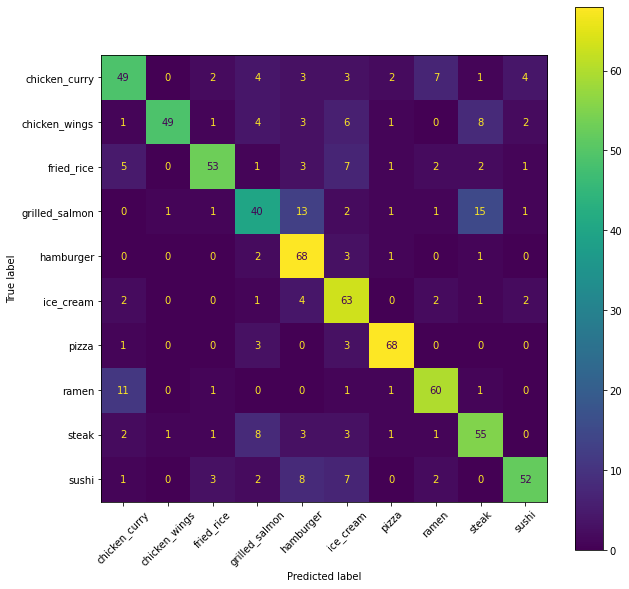

In [198]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf = confusion_matrix(labels, class_pred)
disp = ConfusionMatrixDisplay(conf, display_labels = test_data.class_names)

fig, ax = plt.subplots(figsize = (10,10))
disp.plot(ax = ax)
ax.set_xticklabels(test_data.class_names ,rotation = 45)


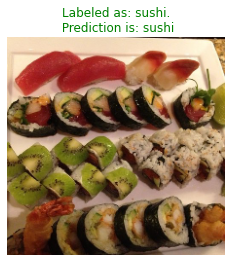

In [233]:
# just visualize prediction
plot_random_prediction(train_data, model)

In [235]:
# Fine Tuning of model

# Unfreeze last 10 layers
for layer in base_model.layers[-10:]:
    print(layer.name) 
    layer.trainable = True

# recompile model
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), #in fine tuning we want small learning rate
                metrics = ["accuracy"])



block7a_se_squeeze
block7a_se_reshape
block7a_se_reduce
block7a_se_expand
block7a_se_excite
block7a_project_conv
block7a_project_bn
top_conv
top_bn
top_activation


In [236]:
history_fine = model.fit(train_data, #Image data generator crate sample with labels
                        epochs=8,
                        steps_per_epoch=len(train_data),
                        validation_data = test_data,
                        validation_steps = len(test_data),
                        initial_epoch = history.epoch[-1] #start training fine tuning after correct epoch
                        )

Epoch 4/8
79/79 [==============================] - 284s 3s/step - loss: 0.6774 - accuracy: 0.7936 - val_loss: 0.9625 - val_accuracy: 0.7547
Epoch 5/8
79/79 [==============================] - 242s 3s/step - loss: 0.6152 - accuracy: 0.8000 - val_loss: 0.9670 - val_accuracy: 0.7547
Epoch 6/8
79/79 [==============================] - 253s 3s/step - loss: 0.5676 - accuracy: 0.8152 - val_loss: 0.9592 - val_accuracy: 0.7533
Epoch 7/8
79/79 [==============================] - 240s 3s/step - loss: 0.6161 - accuracy: 0.7964 - val_loss: 0.9191 - val_accuracy: 0.7587
Epoch 8/8
79/79 [==============================] - 243s 3s/step - loss: 0.5829 - accuracy: 0.8040 - val_loss: 0.9150 - val_accuracy: 0.7600


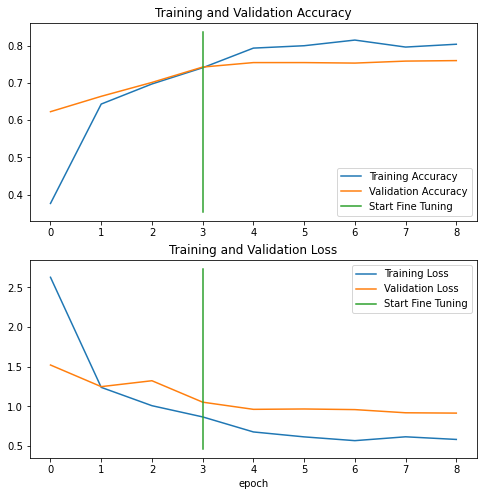

In [238]:
fine_tune_historys(history, history_fine)